# **Risk Stroke Prediction: Capstone Project - Bangkit Academy**
### Compiled by: Machine Learning Team

[Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)



## 1. Introduction and Dataset Information

#### According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
### This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

## 2. Importing Libraries

This section includes the import statements for the required libraries and modules used throughout the project.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from IPython.display import Image, display

## 3. Downloading and Loading the Dataset

This section covers the installation of the Kaggle API, uploading the Kaggle API token, and downloading the dataset directly from Kaggle. It also includes loading the dataset into a pandas DataFrame.

In [2]:
!pip install kaggle

# Upload kaggle.json
files.upload()  # This will prompt you to upload the kaggle.json file

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

# Unzip the dataset
!unzip stroke-prediction-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 87.0MB/s]
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


## 4. Data Preprocessing

This section includes cleaning the dataset by removing missing values and encoding categorical features.

In [3]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# Find rows where BMI is missing
missing_bmi = data[data['bmi'].isna()]

# Count the number of missing BMI values
missing_bmi_count = missing_bmi.shape[0]

# Print the count of missing BMI values
print("Number of Missing BMI Values:", missing_bmi_count)

# Optionally, display the rows with missing BMI
print("Rows with Missing BMI Values:")
print(missing_bmi)

Number of Missing BMI Values: 201
Rows with Missing BMI Values:
         id  gender   age  hypertension  heart_disease ever_married  \
1     51676  Female  61.0             0              0          Yes   
8     27419  Female  59.0             0              0          Yes   
13     8213    Male  78.0             0              1          Yes   
19    25226    Male  57.0             0              1           No   
27    61843    Male  58.0             0              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5039  42007    Male  41.0             0              0           No   
5048  28788    Male  40.0             0              0          Yes   
5093  32235  Female  45.0             1              0          Yes   
5099   7293    Male  40.0             0              0          Yes   
5105  18234  Female  80.0             1              0          Yes   

          work_type Residence_type  avg_glucose_level  bmi   smoking_status  \
1   

In [6]:
data.dropna(inplace=True)

In [7]:
data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In this section, we convert categorical variables into numeric format using Label Encoding. This transformation is essential for machine learning models, which typically require numeric input.

In [8]:
label_encoders = {}
for column in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

## 5. Exploratory Data Analysis (EDA)


In this section, we compute the correlation matrix for the dataset and visualize it using a heatmap. This helps in understanding the relationships between different features.

<Axes: >

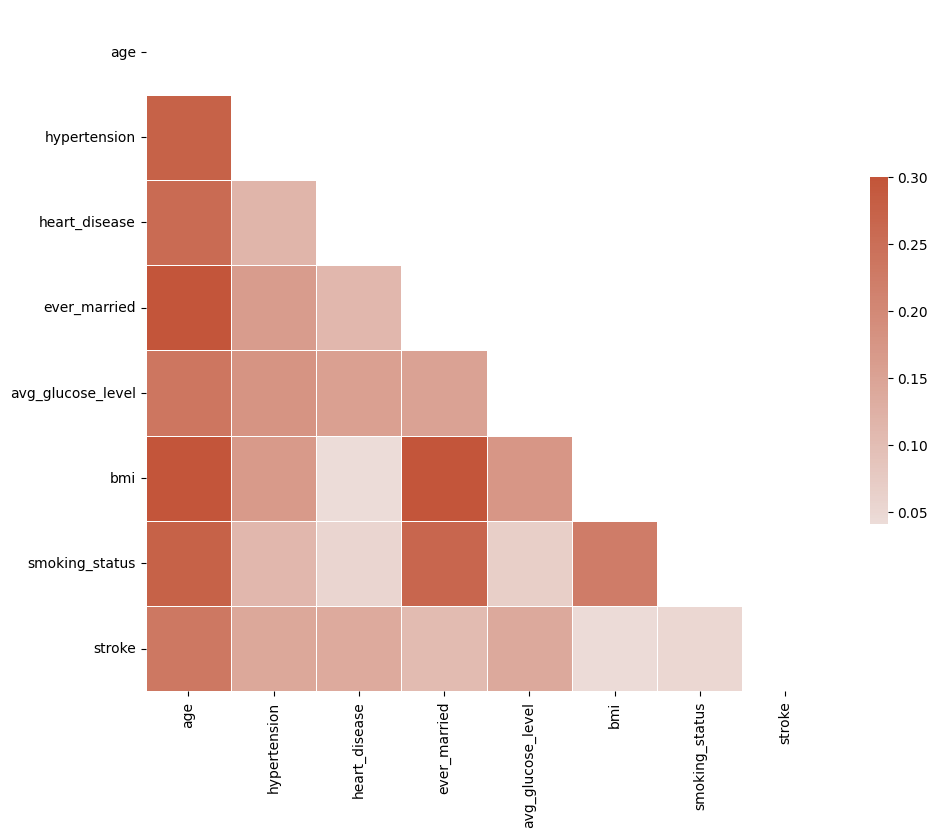

In [9]:
# Compute the correlation matrix
corr = data.drop(columns=['id', 'work_type', 'Residence_type', 'gender']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(590, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the heatmap, we observe that the feature 'age' has the darkest red color, indicating the strongest positive correlation with the target variable (stroke). This suggests that age is a significant factor in predicting stroke, highlighting its importance in the dataset.

This visualization helps in identifying key features that are strongly correlated with each other, aiding in feature selection and providing a deeper understanding of the data.

<ipython-input-10-f00c815977b2>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), fontsize=10)


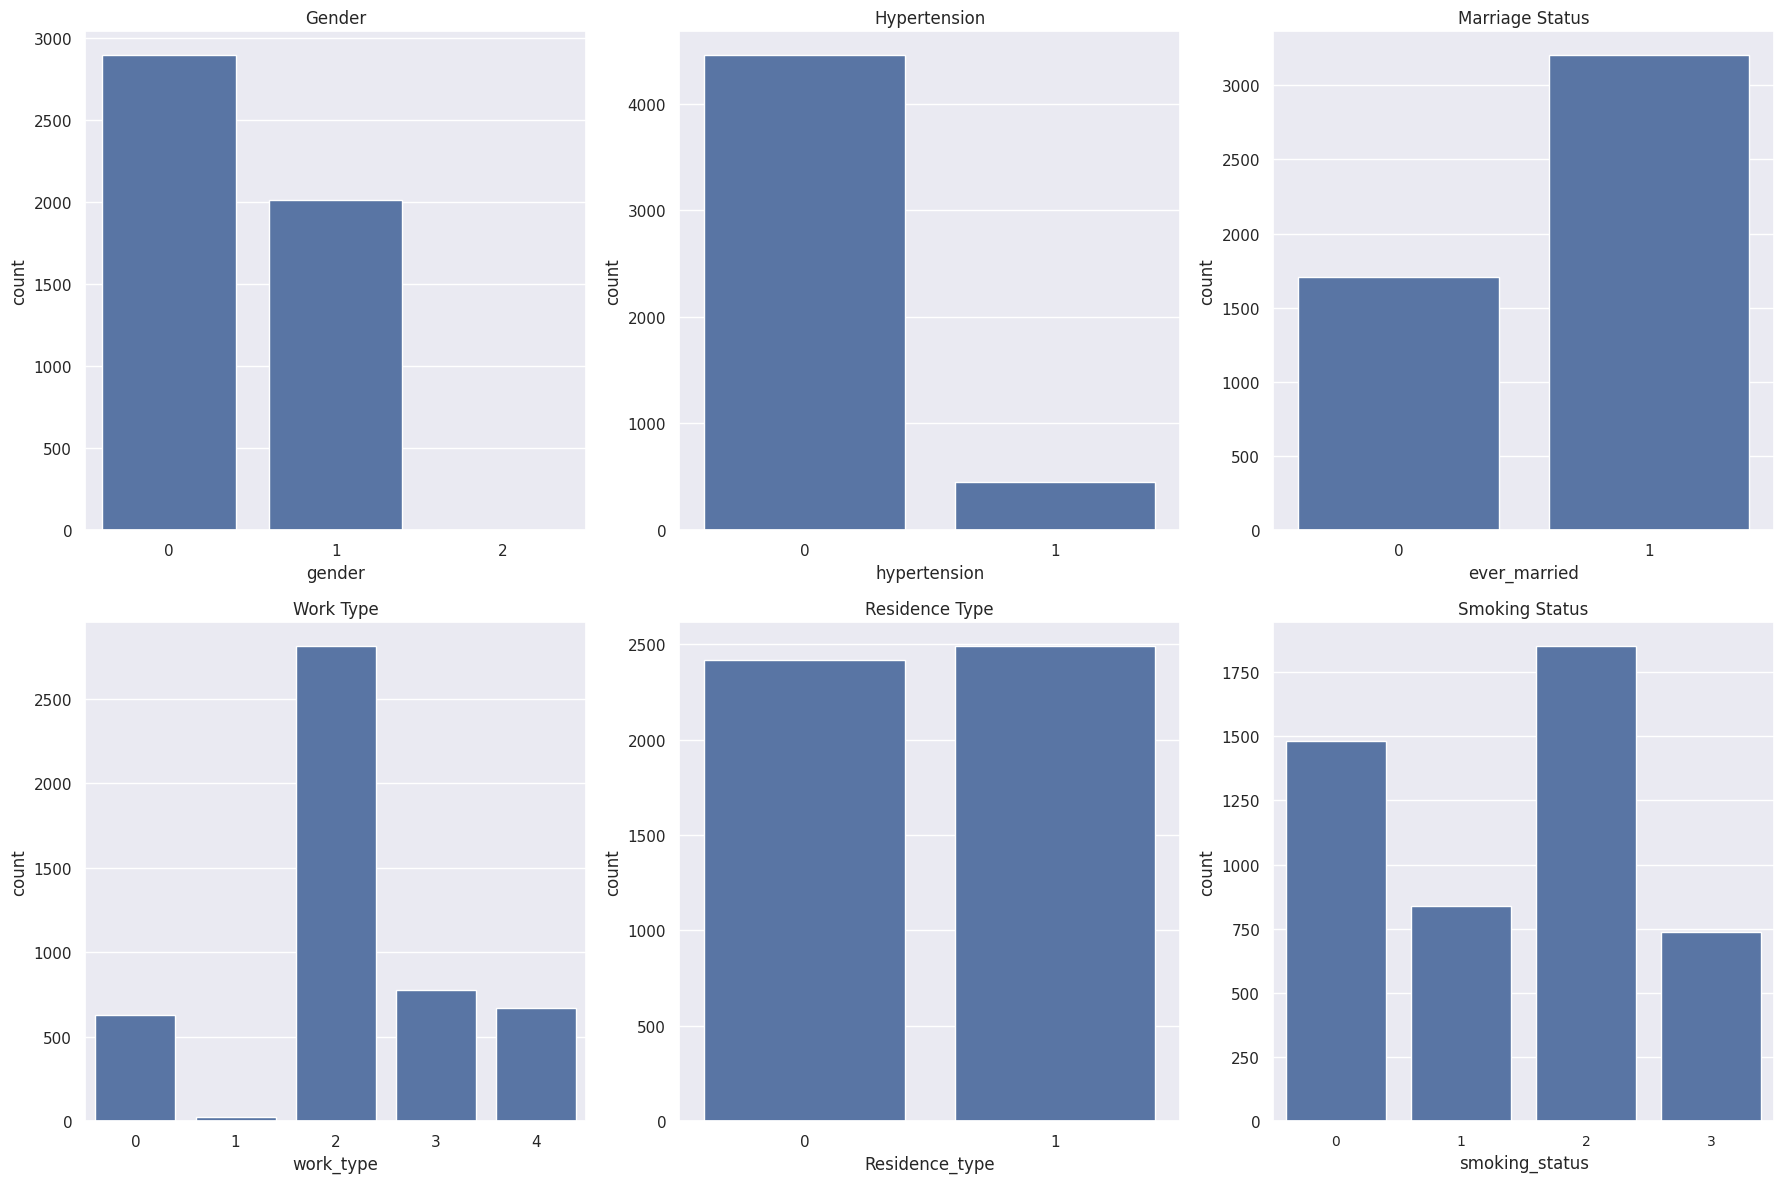

In [10]:
# Set the theme for the plots
sns.set_theme(style="darkgrid")

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot for Gender
sns.countplot(data=data, x="gender", ax=axes[0, 0])
axes[0, 0].set_title('Gender')

# Plot for Hypertension
sns.countplot(data=data, x="hypertension", ax=axes[0, 1])
axes[0, 1].set_title('Hypertension')

# Plot for Marriage Status
sns.countplot(data=data, x="ever_married", ax=axes[0, 2])
axes[0, 2].set_title('Marriage Status')

# Plot for Work Type
sns.countplot(data=data, x="work_type", ax=axes[1, 0])
axes[1, 0].set_title('Work Type')

# Plot for Residence Type
sns.countplot(data=data, x="Residence_type", ax=axes[1, 1])
axes[1, 1].set_title('Residence Type')

# Plot for Smoking Status
sns.countplot(data=data, x="smoking_status", ax=axes[1, 2])
axes[1, 2].set_title('Smoking Status')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), fontsize=10)

# Adjust layout for better fit
plt.tight_layout()
plt.show()



*   Gender: The dataset has more females than males, which should be considered when analyzing gender-specific trends.
*   Hypertension: The majority do not have hypertension, but the presence of hypertension could significantly impact stroke risk.
*   Marriage Status: Most patients are married, which could influence lifestyle factors related to stroke risk.
*   Work Type: The majority work in the private sector, and work type could affect lifestyle and stress levels.
*   Residence Type: An equal distribution between urban and rural residences allows for balanced analysis.
*   Smoking Status: A significant number of patients have never smoked, but the impact of smoking on stroke risk should be carefully analyzed despite the 'Unknown' entries.

This initial analysis provides insights into the demographic and lifestyle-related distributions in the dataset, setting the stage for a more detailed examination of how these factors influence stroke risk.

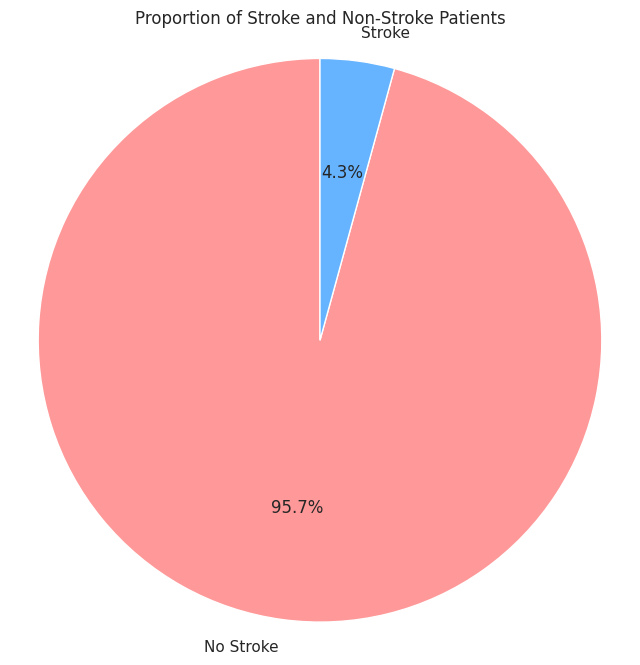

In [11]:
# Count the number of stroke and non-stroke patients
stroke_counts = data['stroke'].value_counts()

# Create labels and sizes for the pie chart
labels = ['No Stroke', 'Stroke']
sizes = [stroke_counts[0], stroke_counts[1]]
colors = ['#ff9999','#66b3ff']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Stroke and Non-Stroke Patients')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 6. Feature Engineering

Applying SMOTE in this dataset helps to address the class imbalance, ensuring that the machine learning model does not become biased towards the majority class and can effectively predict the minority class (stroke patients).

In [12]:
# Separate features and target
X = data.drop(columns=['id', 'stroke'])
y = data['stroke']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
# Reset indices
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Standardize the features and save the scaler parameters for use in a Node.js server.

In [14]:
# Save the scaler parameters to a JSON file
scaler_params = {
    'mean': scaler.mean_.tolist(),
    'var': scaler.var_.tolist(),
    'scale': scaler.scale_.tolist()
}

with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## 7. Model Building

Define, compile, and visualize the neural network architecture.



1.   **Input Layer:** Defines the shape of the input data.
2.   **Dense Layer (128 neurons, ReLU):** Learns patterns from the input data.
3.   **Dropout Layer (0.5):** Prevents overfitting.
4.   **Dense Layer (64 neurons, ReLU):** Refines patterns.
5.   **Dropout Layer (0.5):** Continues to prevent overfitting.
6.   **Dense Layer (32 neurons, ReLU):** Captures more complex relationships.
7.   **Dropout Layer (0.5):** Prevents overfitting.
8.   **Output Layer (1 neuron, Sigmoid):** Produces the final binary prediction.

This architecture is designed to effectively learn and generalize from the training data while preventing overfitting through the use of dropout layers. The final model is compiled with appropriate configurations for binary classification.





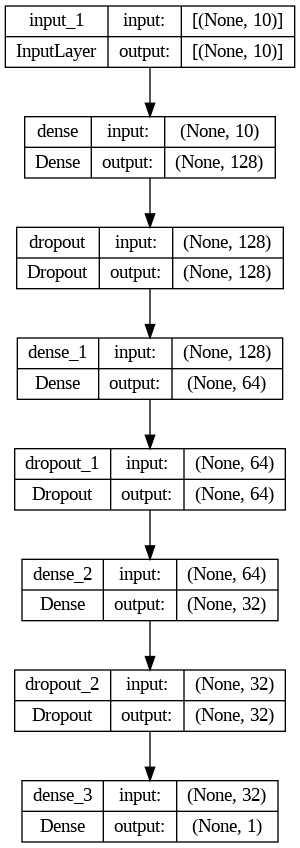

In [15]:
# Define the neural network architecture
def my_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = my_model()

# Plot the model
plot_model(model, to_file='nn_model.png', show_shapes=True, show_layer_names=True)

display(Image('nn_model.png'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 8. Model Evaluation

Train the model and evaluate its performance using accuracy, loss plots, and F1 score to ensure the model is not overfitting.

Train the Model:

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Save the trained model
model.save('/content/keras_model.h5')


Epoch 1/1000
188/188 [==============================] - 5s 5ms/step - loss: 0.5819 - accuracy: 0.6850 - val_loss: 0.4299 - val_accuracy: 0.8125
Epoch 2/1000
188/188 [==============================] - 1s 4ms/step - loss: 0.4583 - accuracy: 0.7862 - val_loss: 0.4022 - val_accuracy: 0.8265
Epoch 3/1000
188/188 [==============================] - 1s 4ms/step - loss: 0.4276 - accuracy: 0.8030 - val_loss: 0.3932 - val_accuracy: 0.8251
Epoch 4/1000
188/188 [==============================] - 1s 4ms/step - loss: 0.4167 - accuracy: 0.8107 - val_loss: 0.3914 - val_accuracy: 0.8271
Epoch 5/1000
188/188 [==============================] - 1s 3ms/step - loss: 0.4047 - accuracy: 0.8230 - val_loss: 0.3800 - val_accuracy: 0.8378
Epoch 6/1000
188/188 [==============================] - 1s 4ms/step - loss: 0.3945 - accuracy: 0.8203 - val_loss: 0.3756 - val_accuracy: 0.8338
Epoch 7/1000
188/188 [==============================] - 1s 4ms/step - loss: 0.3967 - accuracy: 0.8250 - val_loss: 0.3758 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate the Model:

59/59 [==============================] - 0s 1ms/step
F1 Score (Train): 0.9430
F1 Score (Validation): 0.9147


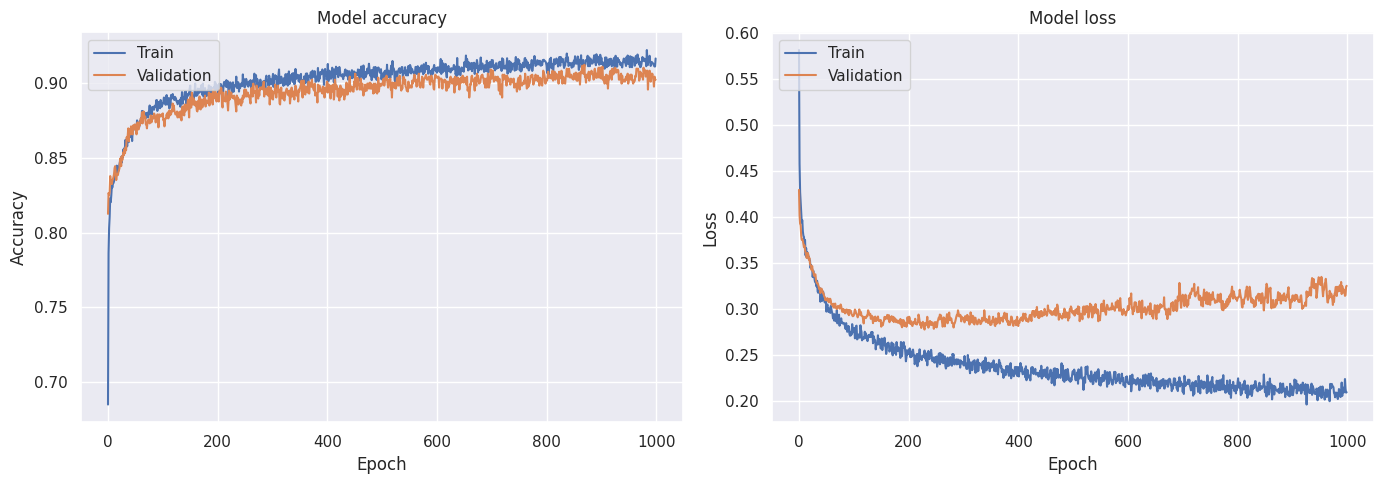

In [17]:
from sklearn.metrics import f1_score

# Predict on the test set
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_pred_val = (model.predict(X_test) > 0.5).astype(int)

# Calculate F1 score for both training and validation sets
f1_train = f1_score(y_train, y_pred_train)
f1_val = f1_score(y_test, y_pred_val)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display F1 scores
print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")

# Show the plots
plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

59/59 [==============================] - 0s 1ms/step


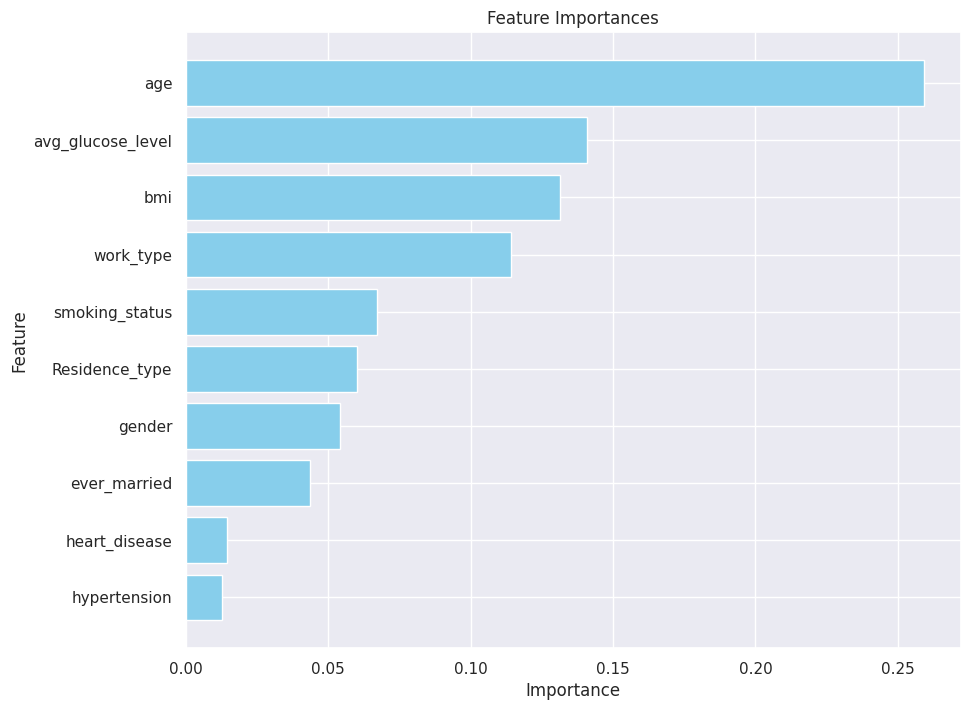

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Load the trained model
model = tf.keras.models.load_model('/content/keras_model.h5')

# Define a function to compute model performance
def model_performance(X, y):
    preds = (model.predict(X) > 0.5).astype(int).flatten()
    accuracy = np.mean(preds == y)
    return accuracy

# Compute the base performance
base_performance = model_performance(X_test, y_test)

# Function to compute permutation feature importance
def compute_permutation_importance(X, y, base_performance):
    feature_importance = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_performance = model_performance(X_permuted, y)
        feature_importance[i] = base_performance - permuted_performance
    return feature_importance

# Compute feature importances
feature_importances = compute_permutation_importance(X_test, y_test, base_performance)

# Create a dataframe for plotting
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


## 9. Converting Javascript

In [19]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
   

In [1]:
!tensorflowjs_converter --input_format=keras /content/keras_model.h5 /content/tfjs_model

2024-06-18 06:13:22.432973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 06:13:22.493943: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 06:13:23.564426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
